# Multi-Class Image Classification on Dogs Breed Dataset, with Amazon Sagemaker 

## Steps taken in this Project

### I Loaded Dogs Breed Dataset, Uploaded in S3 and Checked if Data is uploaded correctly
### II Using Hyper Parameter Search for a Pre-Trained Resnet Model on this dataset
### III Training the model with the best Hyper Params found with Model Debugging and Profiling
### IV Deploy the Model and perform Inference with an Endpoint

## Purpose of the Project

**This Notebook is to demonstrate that using AWS Sagemaker, we can train & fine-tune a pretrained model that can perform image classification by using the Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices. This is done on the Dogs Breed Image Classification Dataset, available publicly**




# Dataset

## We are using the Dogs Breed Multi-Class Classification Dataset

**This dataset contains JPEG images of 133 different Breeds of Dogs. There is a Train, Validation and Test Set present. The Data Distribution is also explained in the following code blocks**



## We have downloaded the dataset and uploaded it to AWS S3
- Uploaded Data to a S3 Bucket
- Checked all data is present currently
- Understood Distribution of Train-Validation-Test

### Dataset Link for Reference

https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip



<h3>Install and import</h3>

In [1]:
%%capture
!pip install smdebug torch torchvision tqdm

In [3]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import IPython

In [2]:
conn = boto3.client('s3')

### Checking All Data is uploaded correctly

In [22]:
bucket = 'sagemaker-studio-88wth0tideu'
#subfolder = 'dogImages/train'
subfolder = 'dogImages/valid'
#subfolder = 'dogImages/test'

In [23]:
contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']

In [24]:
uploaded_set = []
for f in contents:
    #print(f['Key'])
    uploaded_set.append(f['Key'])

In [25]:
original_set = []
f = open("dog_valid.txt", "r+") #Checked for test also
for line in f.readlines():
    #print(line)
    original_set.append(line[:-1])

In [26]:
original_set = set(original_set)

In [27]:
original_set = sorted(original_set)

In [28]:
uploaded_set = set(uploaded_set)

In [29]:
original_set = set(original_set)

In [30]:
data_difference = original_set - uploaded_set

In [31]:
data_difference #Empty means both are same, hence entire data is uploaded

set()

In [32]:
train_folders = []
f = open("dog_train_folders.txt", "r+")
for line in f.readlines():
    #print(line)
    train_folders.append(line[:-1])

In [33]:
train_folders = sorted(train_folders)

In [43]:
i = 0
files_folder_wise = []
for folder in train_folders:
    folder_files = []
    for f in original_set:
        if folder in f:
            folder_files.append(f)
            i+=1
    files_folder_wise.append(folder_files)
    
print(len(files_folder_wise))

133


In [35]:
f_cnt = 0
for folder in train_folders:
    #print(folder)
    sub_f = folder
    i+=1
    try:
        contents = conn.list_objects(Bucket=bucket, Prefix=sub_f)['Contents']
    except:
        print("Folder Doesn't exist")
        print(folder)
        f_cnt+=1
        continue
    uploaded_set = []
    for f in contents:
        #print(f['Key'])
        uploaded_set.append(f['Key'])
    uploaded_set = set(uploaded_set)
    original_set = set(files_folder_wise[f_cnt])
    diff = original_set - uploaded_set
    #print(diff) #For verification that all folders are complete
    f_cnt+=1

### Dataset Distribution Facts

#### Number of Classes (Breeds) = 133

In [36]:
len(files_folder_wise)

133

#### All the Dog Breeds Present in the Dataset

In [37]:
train_folders #Name of each Dog Breed

['dogImages/train/001.Affenpinscher',
 'dogImages/train/002.Afghan_hound',
 'dogImages/train/003.Airedale_terrier',
 'dogImages/train/004.Akita',
 'dogImages/train/005.Alaskan_malamute',
 'dogImages/train/006.American_eskimo_dog',
 'dogImages/train/007.American_foxhound',
 'dogImages/train/008.American_staffordshire_terrier',
 'dogImages/train/009.American_water_spaniel',
 'dogImages/train/010.Anatolian_shepherd_dog',
 'dogImages/train/011.Australian_cattle_dog',
 'dogImages/train/012.Australian_shepherd',
 'dogImages/train/013.Australian_terrier',
 'dogImages/train/014.Basenji',
 'dogImages/train/015.Basset_hound',
 'dogImages/train/016.Beagle',
 'dogImages/train/017.Bearded_collie',
 'dogImages/train/018.Beauceron',
 'dogImages/train/019.Bedlington_terrier',
 'dogImages/train/020.Belgian_malinois',
 'dogImages/train/021.Belgian_sheepdog',
 'dogImages/train/022.Belgian_tervuren',
 'dogImages/train/023.Bernese_mountain_dog',
 'dogImages/train/024.Bichon_frise',
 'dogImages/train/025.Bl

In [38]:
train_set = []
f = open("dog_train.txt", "r+") 
for line in f.readlines():
    #print(line)
    train_set.append(line[:-1])
    
valid_set = []
f = open("dog_valid.txt", "r+") 
for line in f.readlines():
    #print(line)
    valid_set.append(line[:-1])
    
test_set = []
f = open("dog_test.txt", "r+") 
for line in f.readlines():
    #print(line)
    test_set.append(line[:-1])

#### Train Data = 6680 Images

In [39]:
len(train_set)

6680

#### Validation Data = 836 Images

In [40]:
len(valid_set)

835

#### Test Data = 836 Images

In [41]:
len(test_set)

836

#### Total Data = 8351 Images

In [42]:
len(train_set) + len(valid_set) + len(test_set)

8351

### We see that about 80% of Data is for Training, 10% for Validation & 10% for Testing

## Hyperparameter Tuning


**In this step we perform Hyper Parameter Tuning. The script `hpo-gpu.py` helps to perform the tranining, which allows to use a GPU to make it go faster.**

**For tuning Hyper Parameters, I decided to tune the "Learning Rate" & the "Batch Size" Parameters. The reason to do this is that the Learning Rate is often the one responsible for how well the model trains, since an extremely small one can delay training, and a very large one can result in not finding the optima. It is also a very tricky parameter to tune manually, and hence a HP search can help us. We are trying LR from 0.001 till 0.1**

**Similiarly, we tune Batch size as an optimal Batch Size can help the loss decrease faster & learn the weights better. I have provided a good range of Batch Sizes, from 16 till 256, since different models do well with different Batch Sizes**

### Setting up parameters, estimator, and the tuner

In [13]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([16, 32, 64, 128, 256]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [14]:
estimator = PyTorch(
    entry_point="hpo-gpu.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

### Fitting our tuner

In [15]:
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-studio-88wth0tideu/dogImages/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-studio-88wth0tideu/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-studio-88wth0tideu/output/'
tuner.fit({"training": "s3://sagemaker-studio-88wth0tideu/dogImages/"})

................................................................................................................................................................................!


### Describing the tuning results of our last HP Tuning Job


In [9]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220212-1559')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
1       "32"       0.007889  pytorch-training-220212-1559-001-c7801e3b   
0       "64"       0.003895  pytorch-training-220212-1559-002-2e8488c5   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
1         Completed                118.0 2022-02-12 16:03:01+00:00   
0         Completed                 83.0 2022-02-12 16:02:36+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
1 2022-02-12 16:07:22+00:00                       261.0  
0 2022-02-12 16:08:08+00:00                       332.0

In [16]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220212-1658')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
1       "64"       0.049512  pytorch-training-220212-1658-001-5efb6bc6   
0       "16"       0.004109  pytorch-training-220212-1658-002-04111510   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
1         Completed                290.0 2022-02-12 17:01:20+00:00   
0         Completed                 53.0 2022-02-12 17:01:23+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
1 2022-02-12 17:08:52+00:00                       452.0  
0 2022-02-12 17:11:48+00:00                       625.0

<h3>Prepare to perform Training on Best Estimator</h3>

In [17]:
best_estimator=tuner.best_estimator()


2022-02-12 17:11:48 Starting - Preparing the instances for training
2022-02-12 17:11:48 Downloading - Downloading input data
2022-02-12 17:11:48 Training - Training image download completed. Training in progress.
2022-02-12 17:11:48 Uploading - Uploading generated training model
2022-02-12 17:11:48 Completed - Training job completed


In [18]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"16"',
 'learning_rate': '0.004109015897356993',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2022-02-12-16-58-29-112"',
 'sagemaker_program': '"hpo-gpu.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-041772113095/pytorch_dog_hpo-2022-02-12-16-58-29-112/source/sourcedir.tar.gz"'}

### We see that the best Hyper Params for us are Batch Size of 16 and a LR of 0.0041

In [19]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 16, 'learning_rate': '0.004109015897356993'}

## Model Profiling and Debugging

**Using our best HPs, let us create and fine tune a new model.**

**This time, we will also use the SageMaker Debugger and Profiler, to give us more insights about our training process. We have added the hooks in `train_model.py` to use these.**

**We are checking with rules given below, for both the Model Statistics and Resource Statistics**


### Setting up Debugging & Profiling Rules and Hooks

In [21]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [22]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

### Creating and Fitting an Estimator

In [25]:
estimator = PyTorch(
    entry_point='train_model.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    # Params for Debugger and Profiler
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [26]:
estimator.fit({"training": "s3://sagemaker-studio-88wth0tideu/dogImages/"}, wait=False)

## Debugging & Profiling Statistics

**This cell output contains some graphs and the profiler report, which may not be visible properly outside the environment. For clarity, I have attached the pictures of the Profiler Output Plots below this. NOTE THAT all the JSON Data and the Profiler HTML & IPYNB Reports are present in the `ProfilerReport` Folder in the directory**

### Plotting a Debugger Output

Training jobname: dog-pytorch-2022-02-12-17-57-49-250
Region: us-east-1
[2022-02-12 23:25:46.596 ip-172-16-160-26:26259 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-041772113095/dog-pytorch-2022-02-12-17-57-49-250/debug-output
[2022-02-12 23:25:47.277 ip-172-16-160-26:26259 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-12 23:25:48.299 ip-172-16-160-26:26259 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'la

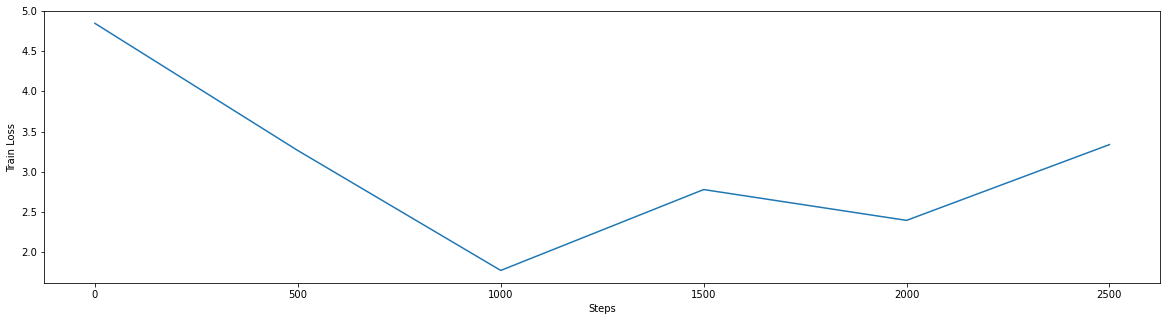

In [8]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

mpl.rcParams['figure.figsize'] = 20, 5

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=modes.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN).values()))
plt.show()

### From the Debugger Output, we see that the training loss was decreasing till 1000 steps, but from there it starts to increase. This indicates that we could use Early Stopping before 1000 steps or train a better or bigger model, with more epochs and observe the trends of loss, to decide when to stop it, or not!

### Profiler Output

In [28]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")



Training jobname: dog-pytorch-2022-02-12-17-57-49-250
Region: us-east-1
[2022-02-12 18:19:55.532 ip-172-16-177-177:3978 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-041772113095/dog-pytorch-2022-02-12-17-57-49-250/debug-output
[2022-02-12 18:19:56.257 ip-172-16-177-177:3978 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-12 18:19:57.281 ip-172-16-177-177:3978 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'la

You will find the profiler report in s3://sagemaker-us-east-1-041772113095/dog-pytorch-2022-02-12-17-57-49-250/rule-output
2022-02-12 18:13:59     370533 dog-pytorch-2022-02-12-17-57-49-250/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-12 18:13:58     219318 dog-pytorch-2022-02-12-17-57-49-250/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-12 18:13:53        566 dog-pytorch-2022-02-12-17-57-49-250/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-12 18:13:53      15426 dog-pytorch-2022-02-12-17-57-49-250/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-12 18:13:53        126 dog-pytorch-2022-02-12-17-57-49-250/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-12 18:13:53        130 dog-pytorch-2022-02-12-17-57-49-250/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-12 18:13:53       4426 do

### Profiler Output Plots Images for Reference Here

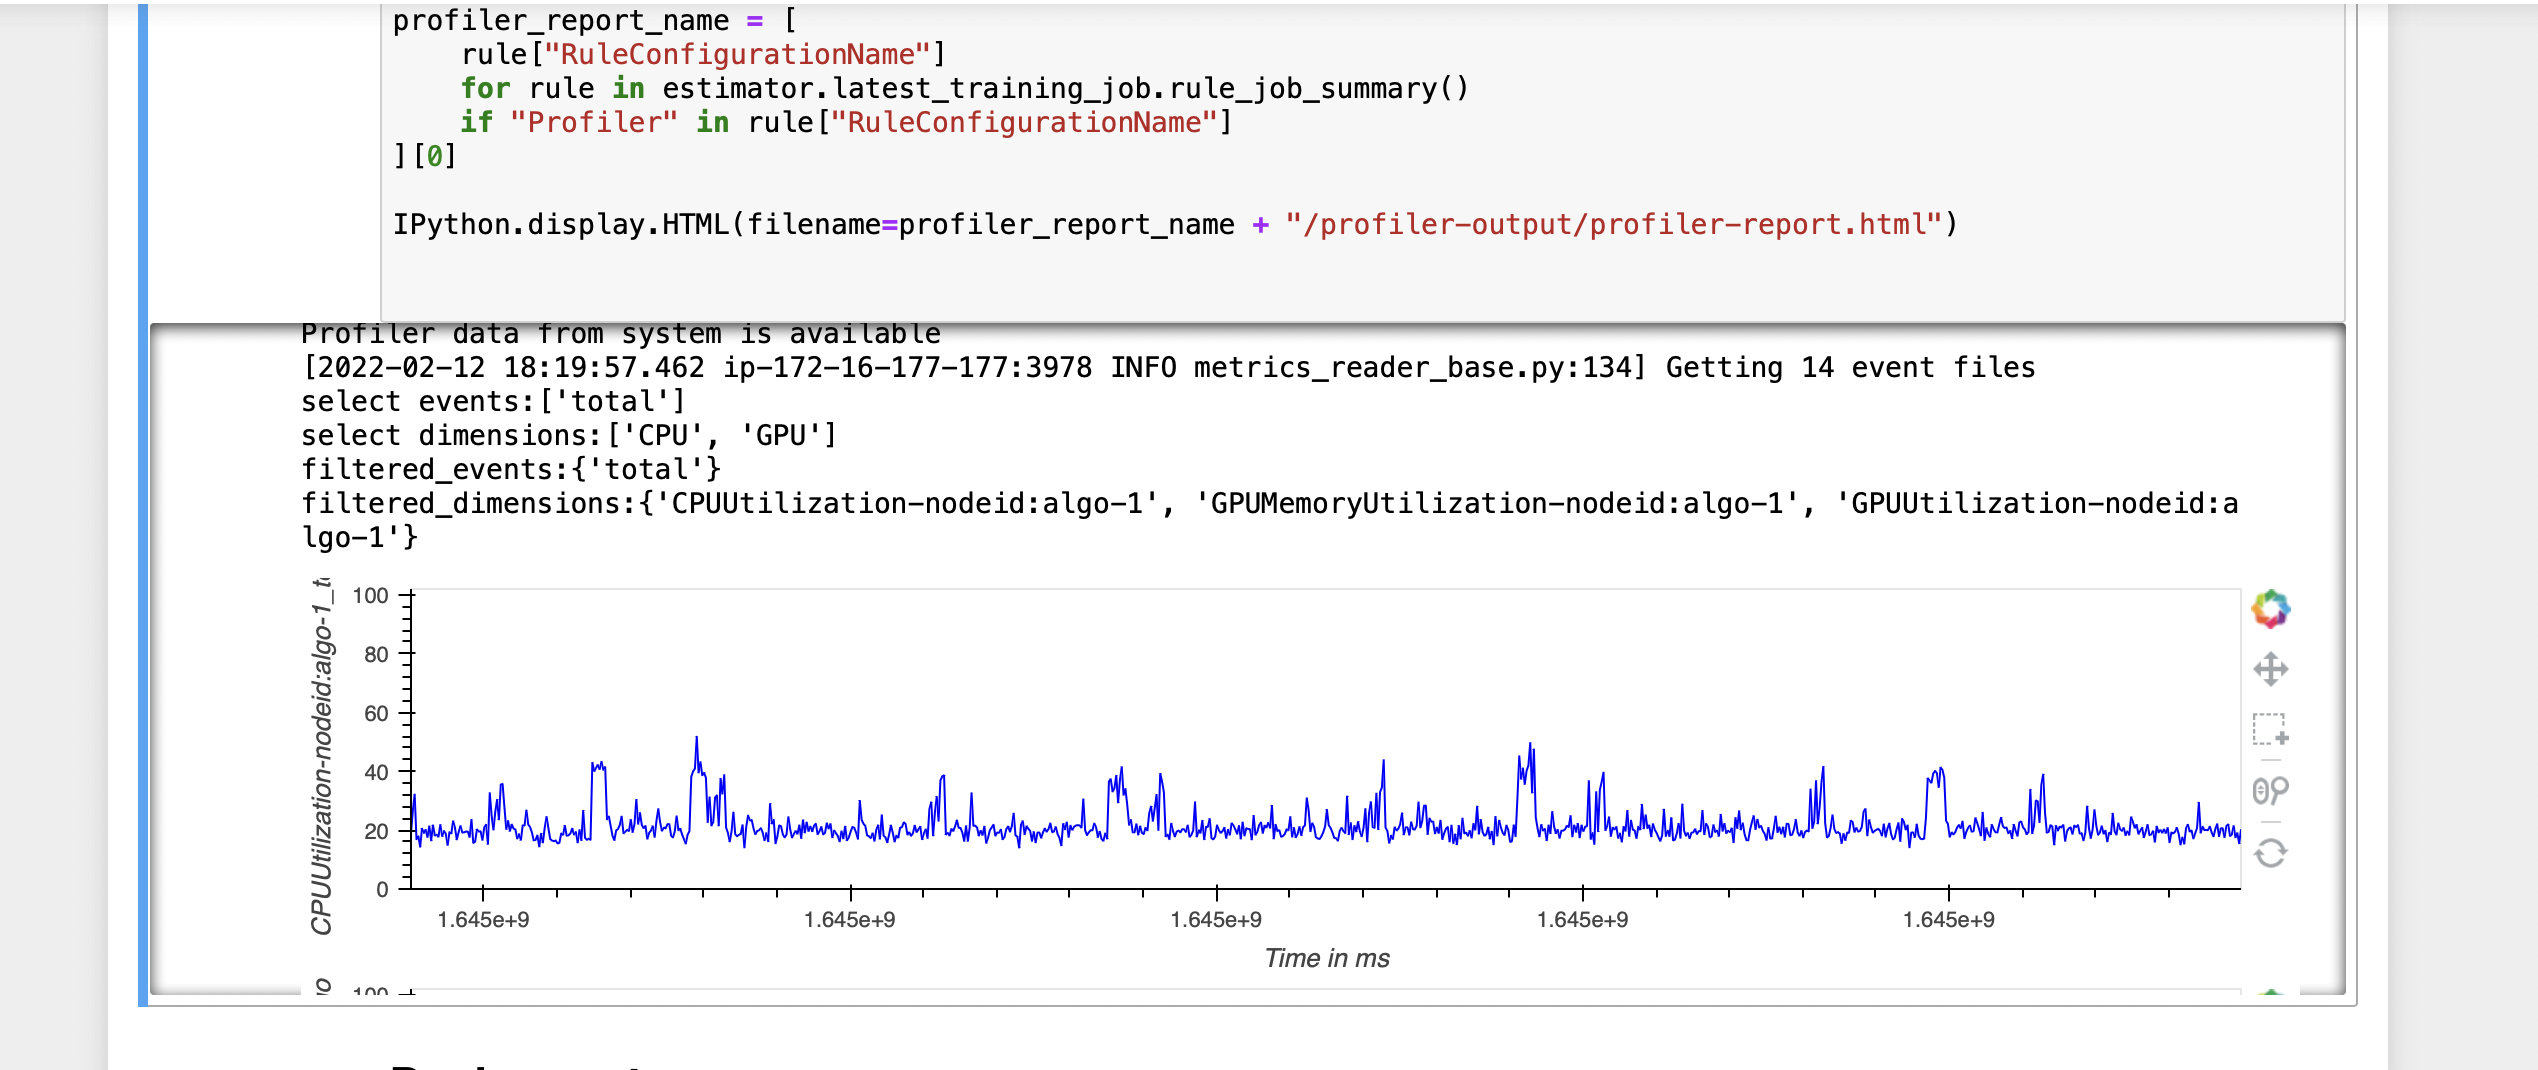

In [4]:
from IPython.display import Image
Image(filename='Profiler Plot - I.png') 

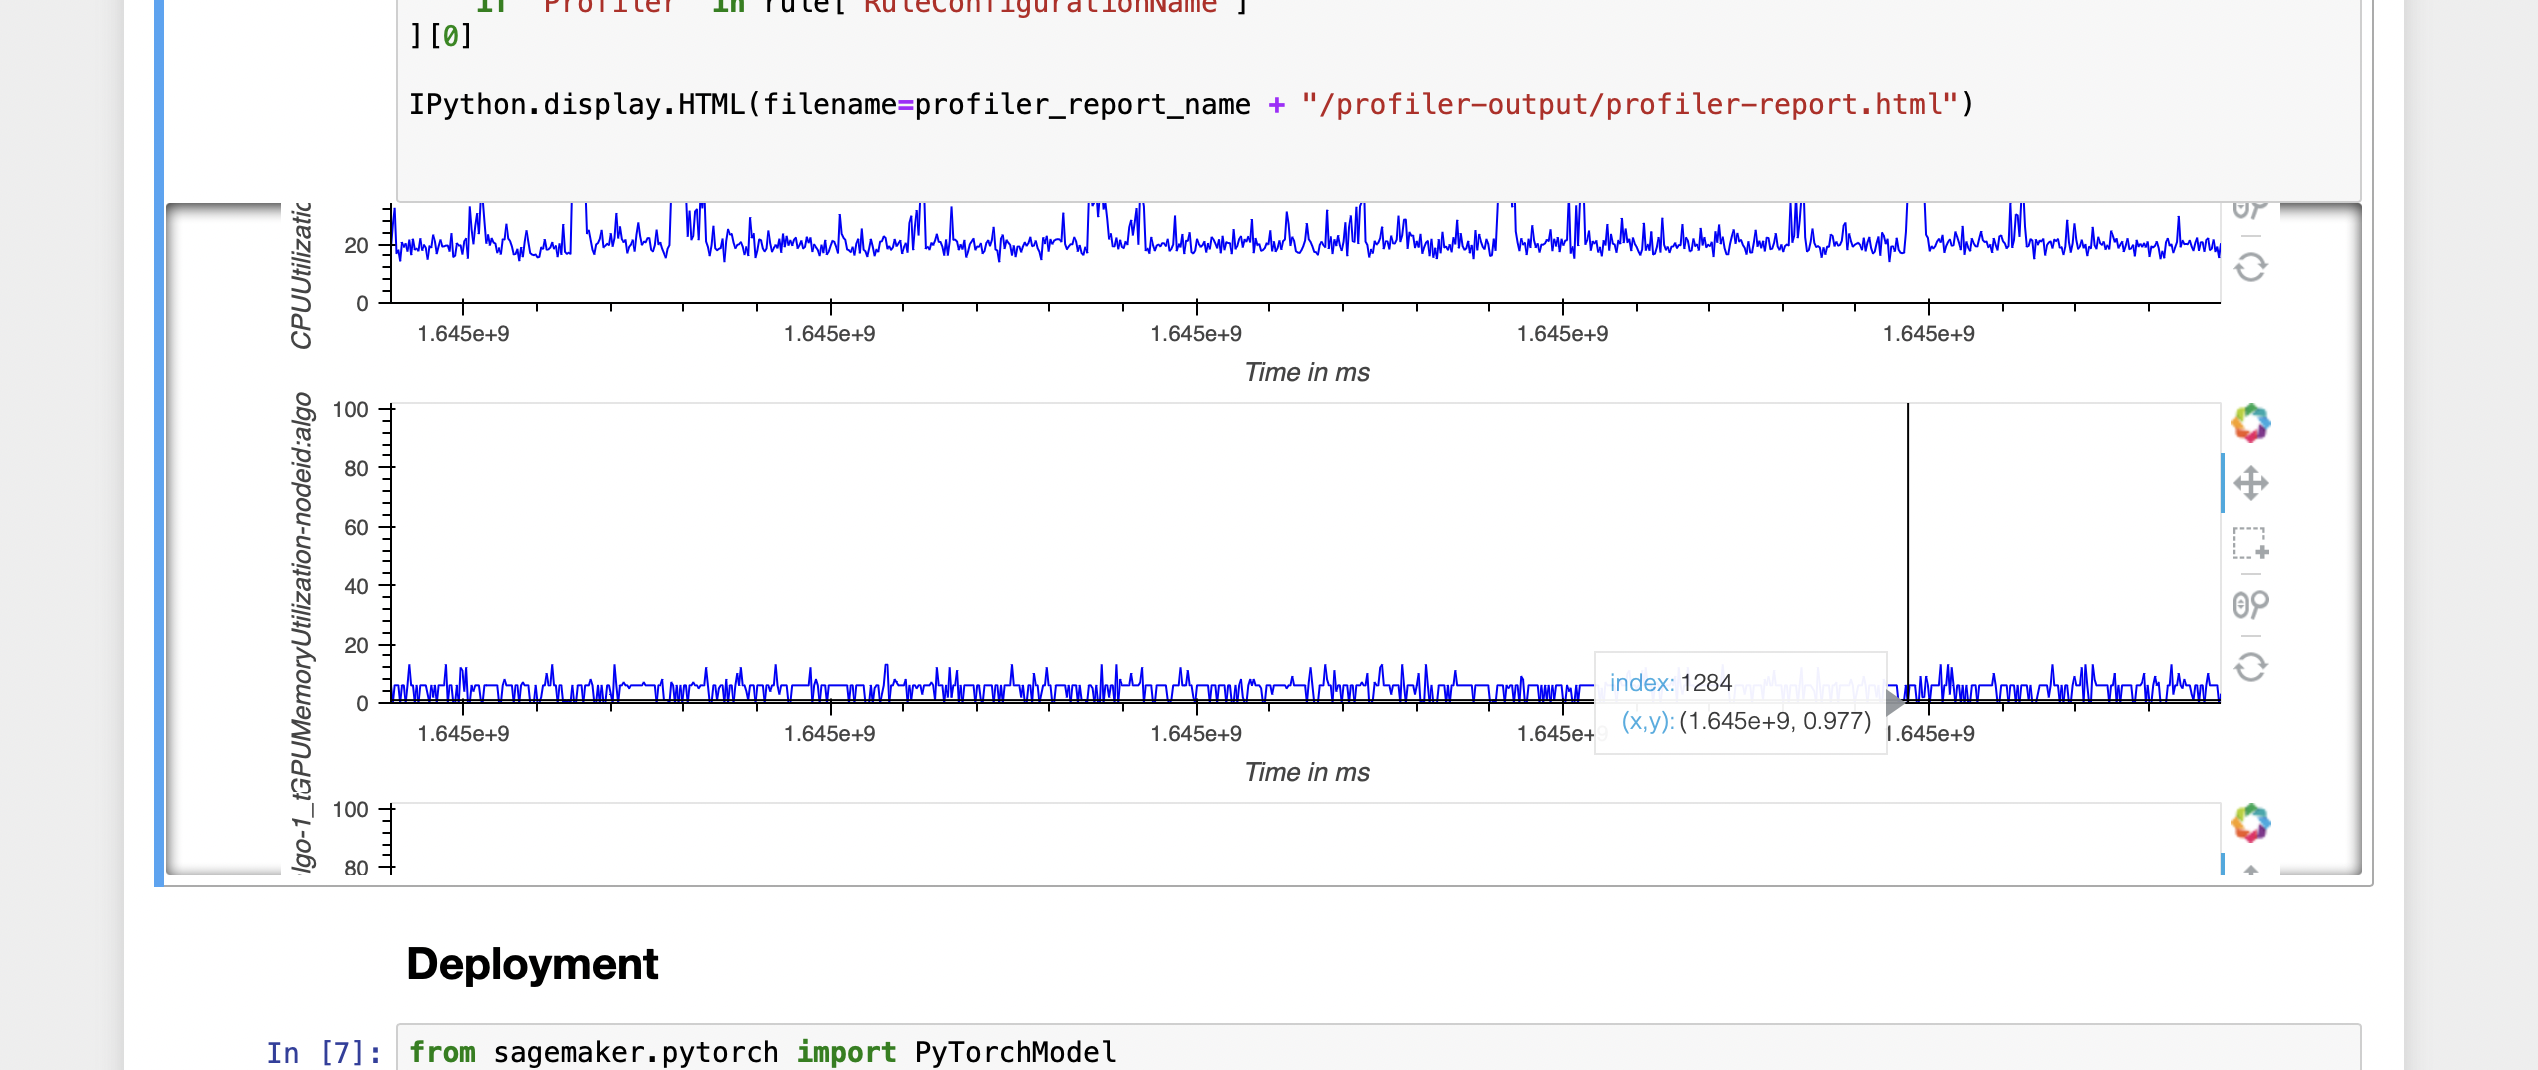

In [5]:
Image(filename='Profiler Plot - II.png') 

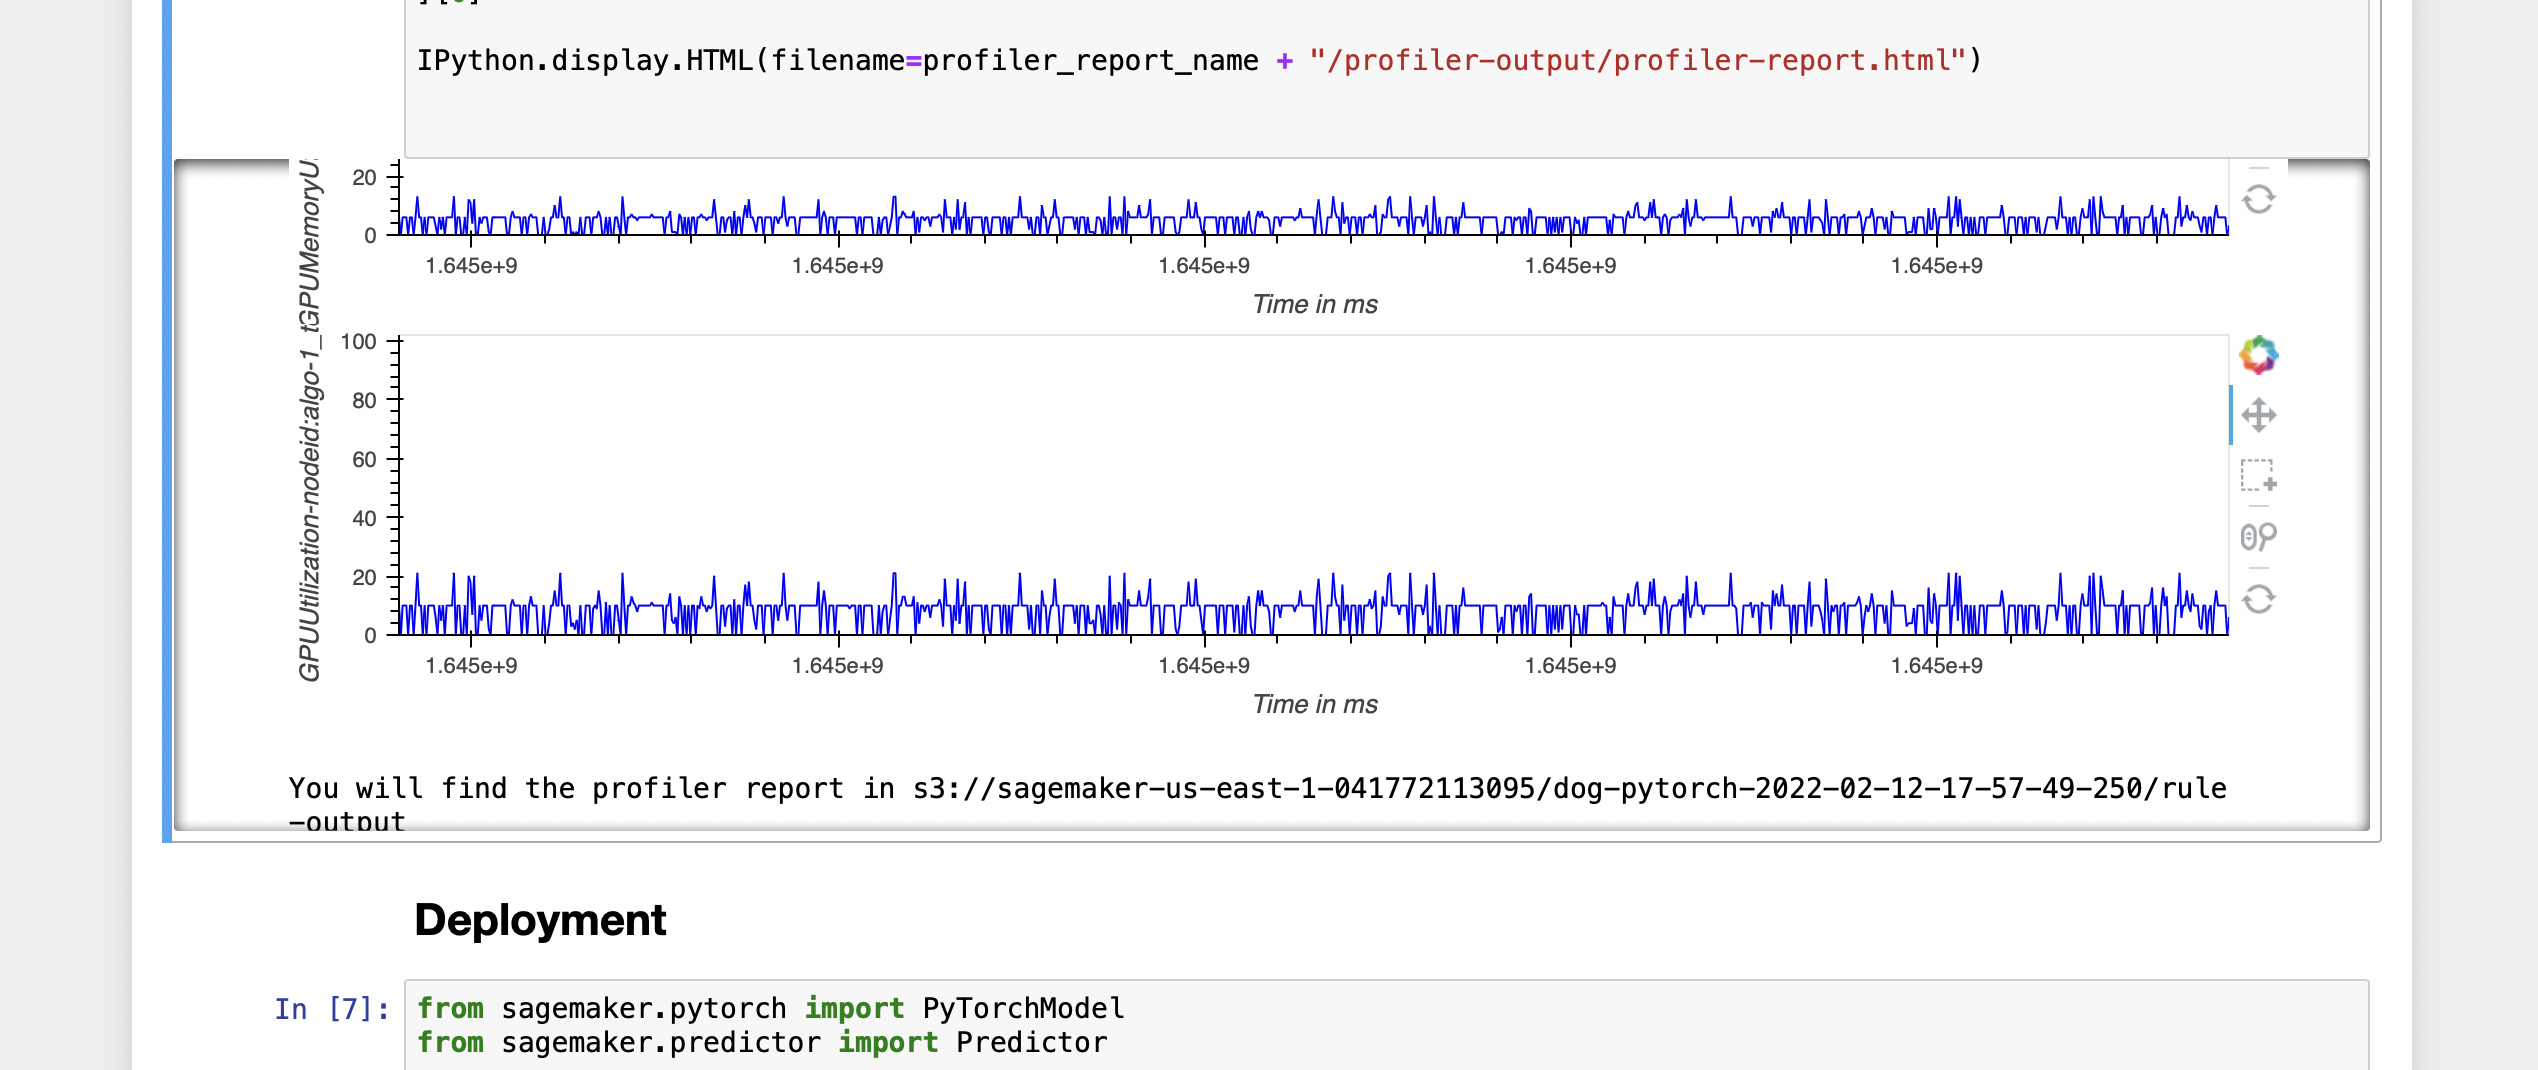

In [6]:
Image(filename='Profiler Plot - III.png') 

### The Profiler Report & Profiler O/P JSON files are in the `ProfilerReport` Folder in the directory

## Model Deployment

In [29]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [36]:
model_location=estimator.model_data


In [37]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [38]:
# We make use of an inference script, for creating a Pytorch Model from the trained model above, 
# which we can query with the endpoint with inputs
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [41]:
#Creating Endpoint with the specified Instance Type and Count
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')


------------!

In [42]:
import requests

request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

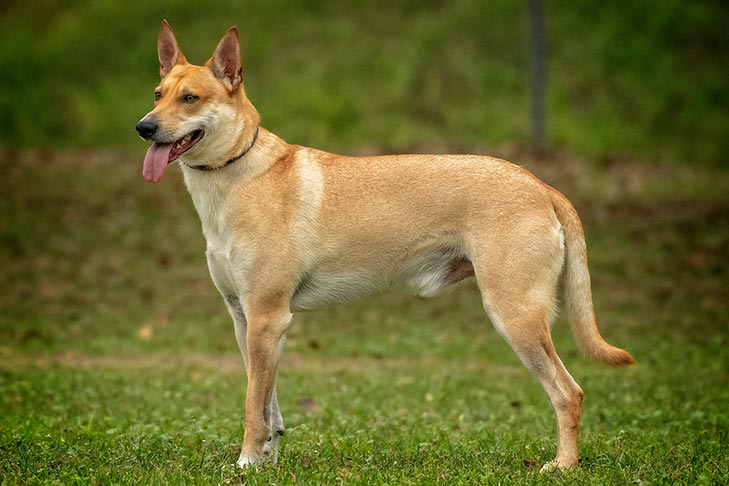

In [43]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes)) #Display Input Picture

In [44]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [48]:
np.argmax(response, 1)

array([70])

**We see that the model predicts the 71st Class, which is a German Shepherd, which seems like a pretty accurate response for the dog in our test picture strongly resembles a German Shepherd, with the pointy ears and brown skin!**

### Deleting Endpoint

In [65]:
predictor.delete_endpoint()

## THE END